# 10785 Project Experiments

In [1]:
import os, time, random, copy, csv
import numpy as np
from PIL import Image

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
import foolbox

## Papernot's attack on resnet18 trained without SDR

### 1. Setup ResNet18 

In [2]:

################################################
# Dataset classes & functions
################################################

def parse_data(path):
    count = 0
    img_list = []
    ID_list = []
    for root, dirs, files in os.walk(path): 
        for file in files: # all files under the same class folder
            if file.endswith('.jpg') and not file.startswith('._'):
                fpath = os.path.join(root, file)
                img_list.append(fpath)
                ID_list.append(int(root.split('/')[-1]))
        #         count += 1
        #         if count >= 6000:
        #             break
        # if count >= 6000:
        #     break
    num_classes = len(set(ID_list))
    print('{}\t\t{}\n{}\t\t{}'.format('#Images', '#Labels', len(img_list), num_classes))
    return img_list, ID_list, num_classes

def parse_data_test(path):
    count = 0
    img_dict = dict()
    for root, dirs, files in os.walk(path): 
        for file in files: # all files under the same class folder
            if file.endswith('.jpg') and not file.startswith('._'):
                fpath = os.path.join(root, file)
                fidx = int(file.replace('.jpg', ''))
                img_dict[fidx] = fpath
    return img_dict

class FaceDataset(Dataset):
    def __init__(self, file_list, target_list, num_classes):
        self.file_list = file_list
        self.target_list = target_list
        self.num_class = num_classes

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img = Image.open(self.file_list[idx])
        img = torchvision.transforms.ToTensor()(img)
        label = self.target_list[idx]
        return img, label

class AdvDataset(Dataset):
    def __init__(self, adv_samples, target_list, num_classes): 
        self.adv_samples = adv_samples
        self.target_list = target_list
        self.num_class = num_classes

    def __len__(self):
        return adv_samples.shape[0]

    def __getitem__(self, idx):
        img = self.adv_samples[idx]
        img = torch.from_numpy(img)
        label = self.target_list[idx]
        return img, label
    
class FaceDataset_test(Dataset):
    def __init__(self, img_dict):
        self.imgs = img_dict

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = Image.open(self.imgs[idx])
        img = torchvision.transforms.ToTensor()(img)
        return img

################################################
# Network n loss classes & functions
################################################

def init_weights(module):
    if type(module) == nn.Conv2d or type(module) == nn.Linear:
        torch.nn.init.xavier_normal_(module.weight.data)

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        stride = 1
        self.downsample = None
        if in_channels != out_channels: # downsampling with stride = 2 required
            stride = 2
            down_layer = nn.Conv2d(in_channels = in_channels, out_channels = out_channels,
                                   kernel_size = 2, stride = stride, bias = False)
            down_bn = nn.BatchNorm2d(num_features = out_channels)
            self.downsample = nn.Sequential(down_layer, down_bn)


        self.block = nn.Sequential(nn.Conv2d(in_channels = in_channels, out_channels = out_channels,
                                             kernel_size = 3, stride = stride, padding = 1, bias = False), # half the map size if need be
                                   nn.BatchNorm2d(num_features = out_channels),
                                   nn.ReLU(inplace = True),
                                   nn.Conv2d(in_channels = out_channels, out_channels = out_channels,
                                             kernel_size = 3, stride = 1, padding = 1, bias = False), # preserve map size
                                   nn.BatchNorm2d(num_features = out_channels))

        self.final_nonlinear = nn.ReLU(inplace = True)

    def forward(self, x):
        # I referenced the original pytorch resnet impelmentation here: https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html#resnet18
        residual = x
        out = self.block(x)
        if self.downsample != None:
            residual = self.downsample(residual)
        out += residual
        out = self.final_nonlinear(out)
        return out

class Face_CNN(nn.Module):
    def __init__(self, num_in_channels, nums_hidden_channels, num_classes):
        super(Face_CNN, self).__init__()
        # Before residual components
        in_layer = nn.Conv2d(in_channels = num_in_channels, 
                             out_channels = nums_hidden_channels[0],
                             kernel_size = 3, stride = 1, padding = 1, bias = False)
        in_bn = nn.BatchNorm2d(num_features = nums_hidden_channels[0])
        in_nonlinear = nn.ReLU(inplace = True)
        self.layers = [in_layer, in_bn, in_nonlinear]

        # Residual components
        for i in range(len(nums_hidden_channels) - 1):
            in_channels = nums_hidden_channels[i]
            out_channels = nums_hidden_channels[i+1]
            self.layers.append(ResBlock(in_channels, out_channels))

        # After residual components: can either go to an MLP clf or flatten as an embedding
        self.layers = nn.Sequential(*self.layers)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.linear_clf = nn.Linear(nums_hidden_channels[-1], num_classes, bias = False)

    def forward(self, x, evalMode = False):
        output = x
        output = self.layers(output) # conv layers
        output = self.avgpool(output).view(output.size(0), -1) # embedding
        clf_out = self.linear_clf(output)
        return clf_out

################################################
# Training n testing classes & functions
################################################

def train(model, optimizer, criterion, train_loader, val_loader, num_epochs, task = 'Classification'):
    print('[LOG] Start Training...')
    
    model.train()

    for epoch in range(num_epochs):
        curr_avg_loss = 0.0
        avg_loss = 0.0

        curr_t = time.time()

        for batch_num, (data, tgts) in enumerate(train_loader):
            if CUDA:
                data = data.cuda()
                tgts = tgts.cuda()

            optimizer.zero_grad()
            outputs = model(data)

            loss = criterion(outputs, tgts.long())
            loss.backward()
            optimizer.step()

            curr_avg_loss += loss.item()

            btemp = 50

            if batch_num % btemp == btemp - 1:
                t_elapsed = (time.time() - curr_t)/batch_num
                est_t_rm = t_elapsed * (6425 - batch_num) / 60
                print('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}\tTime-Remaining: {:.3f}mins'.format(epoch+1, batch_num+1, curr_avg_loss/btemp, est_t_rm))
                curr_avg_loss = 0.0

            torch.cuda.empty_cache()
            del data
            del tgts
            del loss

        epoch_i = epoch + 4

        model_path = 'Res18_0308_epoch_%i.pt' % epoch_i
        save_model(model, model_path)
        print('[LOG] Finish training the current epoch, model saved to %s' % model_path)

        if task == 'Classification':
            val_loss, val_acc = test_classify(model, val_loader, criterion)
            train_loss, train_acc = test_classify(model, train_loader, criterion)
            print('Train Loss: {:.4f}\tTrain Accuracy: {:.4f}\tVal Loss: {:.4f}\tVal Accuracy: {:.4f}'.format(train_loss, train_acc, val_loss, val_acc))

        elif task == 'Verification':
            val_loss, val_acc = test_verify(model, val_loader, criterion)
            train_loss, train_acc = test_verify(model, train_loader, criterion)
            print('Train Loss: {:.4f}\tTrain Accuracy: {:.4f}\tVal Loss: {:.4f}\tVal Accuracy: {:.4f}'.format(train_loss, train_acc, val_loss, val_acc))

def save_model(model, path):
    torch.save(model.state_dict(), path)

In [3]:
#Specify the model
batch_size = 128
CUDA = torch.cuda.is_available()
DEVICE = 'cuda' if CUDA else 'cpu'

# print('[LOG] Loading training and validation data...')
# img_list, label_list, num_classes = parse_data('hw2p2_check/train_data/medium')
# train_dataset = FaceDataset(img_list, label_list, num_classes)
# train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = 4, drop_last = False)

img_list, label_list, num_classes = parse_data('hw2p2_check/validation_classification/medium')
val_dataset = FaceDataset(img_list, label_list, num_classes)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, num_workers = 4, drop_last = False)

print('[LOG] Setting up model...')
hiddens = [64, 64, 64, 128, 128, 256, 256, 512, 512]
model = Face_CNN(3, hiddens, num_classes).to(DEVICE)
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 0.0001)
# criterion = nn.CrossEntropyLoss()

model_path = 'Res18_0308_epoch_4.pt'
model.load_state_dict(torch.load(model_path))
model.eval()
print ('Model is loaded')

#Images		#Labels
4601		2300
[LOG] Setting up model...
Model is loaded


### 2. Generate adversarial samples

In [4]:
def Generate_Adversarial_Samples(model, loader):
    model.eval()
    if CUDA:
        model = model.cuda()
    fmodel = foolbox.models.PyTorchModel(model, bounds=(0, 1), num_classes=num_classes)
    attack = foolbox.attacks.FGSM(fmodel)
    for batch_num, (data, tgts) in enumerate(loader):
        print (batch_num)
        if CUDA:
            data = data.cuda()
            tgts = tgts.cuda()
        for i in range(data.shape[0]):
            w = np.asarray(data[i].view(3,32,32).cpu())
            l = tgts[i].cpu().numpy()
            if batch_num == 0 and i == 0:
                adv_samples = attack(w, l).reshape(1,3,32,32)
            else:
                adv_samples = np.concatenate([adv_samples, attack(w, l).reshape(1,3,32,32)])
    return adv_samples  

In [ ]:
#Generate Adv Samples
adv_samples = Generate_Adversarial_Samples(model, val_dataloader)
#Save the adversarial samples
np.save('val_adv_samples.npy', adv_samples)
print ('Done!')

### Visualize the adversarial samples

#### Original img

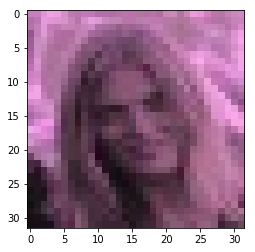

In [26]:
orig = np.uint8(val_dataset.__getitem__(0)[0].numpy()*255)
orig_ = orig.transpose(1,2,0)
plt.imshow(orig_)
plt.show()

#### Perturbed img

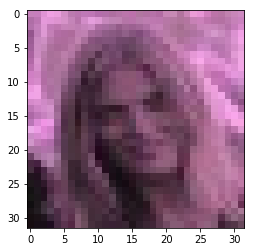

In [27]:
#matplotlib
from matplotlib import pyplot as plt
w = np.uint8(adv_samples[0]*255)
w1 = w.transpose(1,2,0)
plt.imshow(w1)
plt.show()

### 3. Test model performance under attack

In [5]:
def test_classify(model, loader, criterion):
    model.eval()
    test_loss = 0.0
    acc = 0
    total = 0

    for batch_num, (data, tgts) in enumerate(loader):
        if CUDA:
            data = data.cuda()
            tgts = tgts.cuda()
        outputs = model(data)

        _, pred_labels = torch.max(F.softmax(outputs, dim = 1), 1)
        pred_labels = pred_labels.view(-1)

        loss = criterion(outputs, tgts.long())

        acc += torch.sum(torch.eq(pred_labels, tgts)).item()
        batch_size = len(tgts)
        total += batch_size
        test_loss += loss.item() * batch_size

        del data
        del tgts

    model.train()
    return test_loss*1.0/total, acc*1.0/total

In [30]:
criterion = nn.CrossEntropyLoss()
val_loss, val_acc = test_classify(model, val_dataloader, criterion)
#Validation accuracy on non-adversarial samples
print ('Validation Accuracy on non-adversarial samples: '+ str(val_acc))

Validation Accuracy on non-adversarial samples: 0.7370136926755053


In [31]:
#Create Adversarial Dataset
adv_dataset = AdvDataset(adv_samples, label_list, num_classes)
adv_dataloader = DataLoader(adv_dataset, batch_size = batch_size, num_workers = 4, drop_last = False)
adv_loss, adv_acc = test_classify(model, adv_dataloader, criterion)
#Validation accuracy on adversarial samples
print ('Validation Accuracy on non-adversarial samples: '+ str(adv_acc))

Validation Accuracy on non-adversarial samples: 0.0


## Papernot's attack on resnet18 trained with SDR

### 1. Load trained model

In [33]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

hiddens = [64, 64, 64, 128, 128, 256, 256, 512, 512]
model = Face_CNN(3, hiddens, 2300)

model_path = os.path.join('model_epoch_0_ckpt.pt')
model.load_state_dict(torch.load(model_path, map_location = DEVICE))
model = model.to(DEVICE)
print('model loaded')

model loaded


In [34]:
criterion = nn.CrossEntropyLoss()
val_loss, val_acc = test_classify(model, val_dataloader, criterion)
#Validation accuracy on non-adversarial samples
print ('Validation Accuracy on non-adversarial samples: '+ str(val_acc))

Validation Accuracy on non-adversarial samples: 0.72245164094762


#### Tested on adversarial samples generated using the non-sdr trained model (surrogate)

In [35]:
#Create Adversarial Dataset
adv_dataset = AdvDataset(adv_samples, label_list, num_classes)
adv_dataloader = DataLoader(adv_dataset, batch_size = batch_size, num_workers = 4, drop_last = False)
adv_loss, adv_acc = test_classify(model, adv_dataloader, criterion)
#Validation accuracy on adversarial samples
print ('Validation Accuracy on non-adversarial samples: '+ str(adv_acc))

Validation Accuracy on non-adversarial samples: 0.6494240382525538


#### Tested on adversarial samples generated using the sdr trained model

In [ ]:
#Generate Adv Samples
adv_samples = Generate_Adversarial_Samples(model, val_dataloader)
#Save the adversarial samples
np.save('val_adv_samples_sdr.npy', adv_samples)
print ('Done!')

In [37]:
#Create Adversarial Dataset
adv_dataset = AdvDataset(adv_samples, label_list, num_classes)
adv_dataloader = DataLoader(adv_dataset, batch_size = batch_size, num_workers = 4, drop_last = False)
adv_loss, adv_acc = test_classify(model, adv_dataloader, criterion)
#Validation accuracy on adversarial samples
print ('Validation Accuracy on adversarial samples: '+ str(adv_acc))

Validation Accuracy on non-adversarial samples: 0.0


### 2. Another trained model with higher validation accuracy

In [6]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

hiddens = [64, 64, 64, 128, 128, 256, 256, 512, 512]
model1 = Face_CNN(3, hiddens, 2300)

model_path1 = os.path.join('model_epoch_14_ckpt.pt')
model1.load_state_dict(torch.load(model_path1, map_location = DEVICE))
model1 = model1.to(DEVICE)
print('model loaded')

model loaded


In [7]:
criterion = nn.CrossEntropyLoss()
val_loss, val_acc = test_classify(model1, val_dataloader, criterion)
#Validation accuracy on non-adversarial samples
print ('Validation Accuracy on non-adversarial samples: '+ str(val_acc))

Validation Accuracy on non-adversarial samples: 0.7346229080634644


In [8]:
#Generate Adv Samples
adv_samples1 = Generate_Adversarial_Samples(model1, val_dataloader)
#Save the adversarial samples
np.save('val_adv_samples_sdr1.npy', adv_samples1)
print ('Done!')

0


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
Done!


In [13]:
adv_samples = adv_samples1

In [16]:
#Create Adversarial Dataset
adv_dataset = AdvDataset(adv_samples, label_list, num_classes)
adv_dataloader = DataLoader(adv_dataset, batch_size = batch_size, num_workers = 4, drop_last = False)
adv_loss, adv_acc = test_classify(model1, adv_dataloader, criterion)
#Validation accuracy on adversarial samples
print ('Validation Accuracy on adversarial samples: '+ str(adv_acc))

Validation Accuracy on non-adversarial samples: 0.0


In [ ]:
# model = model.cpu()
# fmodel = foolbox.models.PyTorchModel(model, bounds=(0, 1), num_classes=num_classes, device='cpu')
# attack = foolbox.attacks.FGSM(fmodel)
# model(data[0].view(1,3,32,32))
# w = np.asarray(data[0].view(3,32,32))
# fmodel.predictions(w)
# l = tgt[0].numpy()
# e = attack(w,l)
# print ('done')

# x = np.zeros((1,2,3))
# y = np.zeros((1,2,3))
# w = np.concatenate([x,y])
# w.shape